In [1]:
import pathlib
import tomllib
import haiku as hk
import jax
import jax.numpy as jnp
import orbax.checkpoint as ocp
import matplotlib.pyplot as plt

from causal_conv_arm.arm import ARM
from causal_conv_arm.utils import plot_grid

In [2]:
config_path = pathlib.Path("../configs/train.toml")

In [3]:
with config_path.open('rb') as file:
    config = tomllib.load(file)

In [4]:
@hk.without_apply_rng
@hk.transform
def loglikelihood(xs):
    model = ARM(**config['model'])
    return model.loglikelihood(xs)

@hk.transform
def sample(x_seed):
    model = ARM(**config['model'])
    return model.sample(x_seed)

sample_fn = jax.jit(sample.apply)

key = jax.random.key(config['seed'])
xs_dummy = jnp.empty((1, config['n_elements']), dtype=jnp.int32)

params = loglikelihood.init(key, xs_dummy)

Could not load symbol cuFuncGetName. Error: /lib64/libcuda.so.1: undefined symbol: cuFuncGetName


In [5]:
checkpoints_dir = pathlib.Path("../data/checkpoints").resolve()

In [6]:
ckpt_mngr = ocp.CheckpointManager(checkpoints_dir)

best_step = None
latest_step = None
try:
    best_step = ckpt_mngr.best_step()
except Exception:
    best_step = None

try:
    latest_step = ckpt_mngr.latest_step()
except Exception:
    latest_step = None

step_to_restore = best_step if best_step is not None else latest_step
print('best_step:', best_step, 'latest_step:', latest_step)

best_step: 22 latest_step: 22


In [7]:
restored_params = ckpt_mngr.restore(step_to_restore, args=ocp.args.StandardRestore(params))
params = restored_params
print(f'Restored checkpoint step: {step_to_restore}')

Restored checkpoint step: 22


In [8]:
%load_ext tensorboard

In [9]:
%tensorboard --logdir='../runs'

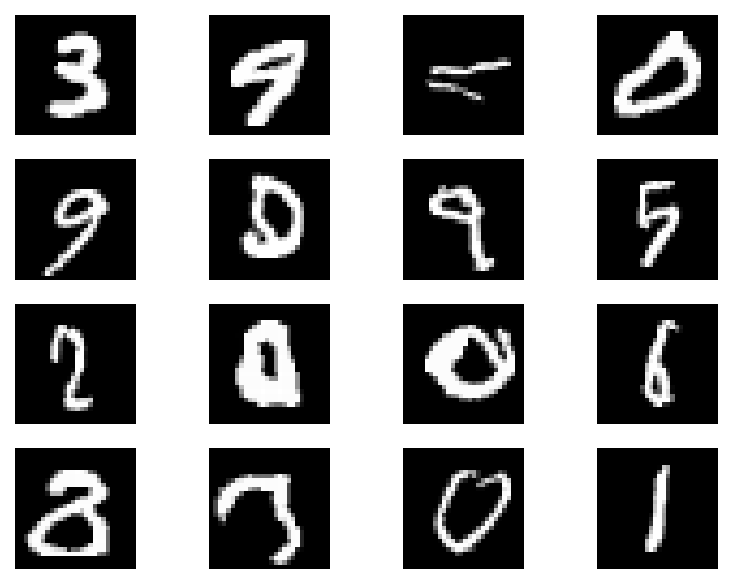

In [10]:
key, subkey = jax.random.split(key)
sample_seed = jnp.zeros((config['generation_batch_size'], config['n_elements']), dtype=jnp.int32)
samples = sample_fn(params, subkey, sample_seed)

plot_grid(samples, shape=(28, 28), dpi=150)
plt.show()